In [1]:
import numpy as np
import pandas as pd
from spec_id import Gen_spec
import matplotlib.pyplot as plt
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
colmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)
pandas2ri.activate()

In [3]:
galDB = pd.read_pickle('../data/sgal_param_DB.pkl')
metal=np.arange(0.002,0.031,0.001)
age=np.arange(.5,6.1,.1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [4]:
rzoo = importr('zoo')

In [5]:
waves = np.array([])
flux = np.array([])
error = np.array([])
mflux = np.array([])

for i in galDB.index:
    spec = Gen_spec(galDB['gids'][i],galDB['hi_res_specz'][i],maxwv=11400)
    spec.Median_spec(galDB['Z_f'][i],galDB['t_f'][i],tau)
    waves = np.append(waves,spec.gal_wv_rf[spec.gal_fl > 1E-21])
    flux = np.append(flux,spec.gal_fl[spec.gal_fl > 1E-21])
    error = np.append(error,spec.gal_er[spec.gal_fl > 1E-21])
    mflux = np.append(mflux,spec.fl[spec.gal_fl > 1E-21])

The following tasks in the stwcs.gui package can be run with TEAL:
     apply_headerlet          archive_headerlet          attach_headerlet     
     delete_headerlet         extract_headerlet         headerlet_summary     
    restore_headerlet             updatewcs              write_headerlet




../data/galaxy_flts/n14713_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n14713_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n14713_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n14713_flt: save ../data/galaxy_flts/n14713_flt.detect_seg.fits, ../data/galaxy_flts/n14713_flt.detect.cat


/Users/Vince.ec/anaconda2/envs/astroconda/lib/python2.7/site-packages/grizli/model.py:496: RuntimeWarning: invalid value encountered in divide
  self.optimal_profile = m/m.sum(axis=0)


../data/galaxy_flts/n16758_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n16758_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n16758_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n16758_flt: save ../data/galaxy_flts/n16758_flt.detect_seg.fits, ../data/galaxy_flts/n16758_flt.detect.cat


../data/galaxy_flts/n17070_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n17070_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n17070_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n17070_flt: save ../data/galaxy_flts/n17070_flt.detect_seg.fits, ../data/galaxy_flts/n17070_flt.detect.cat


../data/galaxy_flts/n19442_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n19442_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n19442_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n19442_flt: save ../data/galaxy_flts/n19442_flt.detect_seg.fits, ../data/galaxy_flts/n19442_flt.detect.cat


../data/galaxy_flts/n21156_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21156_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21156_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21156_flt: save ../data/galaxy_flts/n21156_flt.detect_seg.fits, ../data/galaxy_flts/n21156_flt.detect.cat


../data/galaxy_flts/n21427_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n21427_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n21427_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n21427_flt: save ../data/galaxy_flts/n21427_flt.detect_seg.fits, ../data/galaxy_flts/n21427_flt.detect.cat


../data/galaxy_flts/n23435_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n23435_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n23435_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n23435_flt: save ../data/galaxy_flts/n23435_flt.detect_seg.fits, ../data/galaxy_flts/n23435_flt.detect.cat


../data/galaxy_flts/n32566_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n32566_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n32566_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n32566_flt: save ../data/galaxy_flts/n32566_flt.detect_seg.fits, ../data/galaxy_flts/n32566_flt.detect.cat


../data/galaxy_flts/n34694_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n34694_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n34694_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n34694_flt: save ../data/galaxy_flts/n34694_flt.detect_seg.fits, ../data/galaxy_flts/n34694_flt.detect.cat


../data/galaxy_flts/n37686_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n37686_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n37686_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n37686_flt: save ../data/galaxy_flts/n37686_flt.detect_seg.fits, ../data/galaxy_flts/n37686_flt.detect.cat


../data/galaxy_flts/n38126_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/n38126_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/n38126_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/n38126_flt: save ../data/galaxy_flts/n38126_flt.detect_seg.fits, ../data/galaxy_flts/n38126_flt.detect.cat


/Users/Vince.ec/anaconda2/envs/astroconda/lib/python2.7/site-packages/grizli/model.py:998: RuntimeWarning: invalid value encountered in less
  bad = self.data['SCI'] < sigma*self.data['ERR']


../data/galaxy_flts/s35774_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s35774_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s35774_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s35774_flt: save ../data/galaxy_flts/s35774_flt.detect_seg.fits, ../data/galaxy_flts/s35774_flt.detect.cat


../data/galaxy_flts/s38785_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s38785_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s38785_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s38785_flt: save ../data/galaxy_flts/s38785_flt.detect_seg.fits, ../data/galaxy_flts/s38785_flt.detect.cat


../data/galaxy_flts/s39012_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39012_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39012_flt: photutils.source_properties - 5 objects
../data/galaxy_flts/s39012_flt: save ../data/galaxy_flts/s39012_flt.detect_seg.fits, ../data/galaxy_flts/s39012_flt.detect.cat


../data/galaxy_flts/s39170_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39170_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39170_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39170_flt: save ../data/galaxy_flts/s39170_flt.detect_seg.fits, ../data/galaxy_flts/s39170_flt.detect.cat


../data/galaxy_flts/s39241_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39241_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39241_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39241_flt: save ../data/galaxy_flts/s39241_flt.detect_seg.fits, ../data/galaxy_flts/s39241_flt.detect.cat


../data/galaxy_flts/s39631_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39631_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39631_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39631_flt: save ../data/galaxy_flts/s39631_flt.detect_seg.fits, ../data/galaxy_flts/s39631_flt.detect.cat


../data/galaxy_flts/s39804_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39804_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39804_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39804_flt: save ../data/galaxy_flts/s39804_flt.detect_seg.fits, ../data/galaxy_flts/s39804_flt.detect.cat


../data/galaxy_flts/s39805_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s39805_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s39805_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s39805_flt: save ../data/galaxy_flts/s39805_flt.detect_seg.fits, ../data/galaxy_flts/s39805_flt.detect.cat


../data/galaxy_flts/s40223_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40223_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40223_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40223_flt: save ../data/galaxy_flts/s40223_flt.detect_seg.fits, ../data/galaxy_flts/s40223_flt.detect.cat


../data/galaxy_flts/s40476_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40476_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40476_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40476_flt: save ../data/galaxy_flts/s40476_flt.detect_seg.fits, ../data/galaxy_flts/s40476_flt.detect.cat


../data/galaxy_flts/s40597_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40597_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40597_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40597_flt: save ../data/galaxy_flts/s40597_flt.detect_seg.fits, ../data/galaxy_flts/s40597_flt.detect.cat


../data/galaxy_flts/s40623_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40623_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40623_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40623_flt: save ../data/galaxy_flts/s40623_flt.detect_seg.fits, ../data/galaxy_flts/s40623_flt.detect.cat


../data/galaxy_flts/s40862_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s40862_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s40862_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s40862_flt: save ../data/galaxy_flts/s40862_flt.detect_seg.fits, ../data/galaxy_flts/s40862_flt.detect.cat


../data/galaxy_flts/s41148_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41148_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41148_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41148_flt: save ../data/galaxy_flts/s41148_flt.detect_seg.fits, ../data/galaxy_flts/s41148_flt.detect.cat


../data/galaxy_flts/s41520_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41520_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41520_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s41520_flt: save ../data/galaxy_flts/s41520_flt.detect_seg.fits, ../data/galaxy_flts/s41520_flt.detect.cat


../data/galaxy_flts/s41659_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s41659_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s41659_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s41659_flt: save ../data/galaxy_flts/s41659_flt.detect_seg.fits, ../data/galaxy_flts/s41659_flt.detect.cat


../data/galaxy_flts/s43615_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s43615_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s43615_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s43615_flt: save ../data/galaxy_flts/s43615_flt.detect_seg.fits, ../data/galaxy_flts/s43615_flt.detect.cat


../data/galaxy_flts/s44042_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44042_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44042_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44042_flt: save ../data/galaxy_flts/s44042_flt.detect_seg.fits, ../data/galaxy_flts/s44042_flt.detect.cat


../data/galaxy_flts/s44620_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s44620_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s44620_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s44620_flt: save ../data/galaxy_flts/s44620_flt.detect_seg.fits, ../data/galaxy_flts/s44620_flt.detect.cat


../data/galaxy_flts/s45972_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s45972_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s45972_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s45972_flt: save ../data/galaxy_flts/s45972_flt.detect_seg.fits, ../data/galaxy_flts/s45972_flt.detect.cat


../data/galaxy_flts/s46066_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46066_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46066_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46066_flt: save ../data/galaxy_flts/s46066_flt.detect_seg.fits, ../data/galaxy_flts/s46066_flt.detect.cat


../data/galaxy_flts/s46345_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s46345_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s46345_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s46345_flt: save ../data/galaxy_flts/s46345_flt.detect_seg.fits, ../data/galaxy_flts/s46345_flt.detect.cat


../data/galaxy_flts/s47677_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s47677_flt: photutils.source_properties
Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s47677_flt: photutils.source_properties - 1 objects
../data/galaxy_flts/s47677_flt: save ../data/galaxy_flts/s47677_flt.detect_seg.fits, ../data/galaxy_flts/s47677_flt.detect.cat


../data/galaxy_flts/s48631_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
../data/galaxy_flts/s48631_flt: photutils.source_properties


Rename column: ycentroid -> y_flt
Rename column: ra_icrs_centroid -> ra
Rename column: dec_icrs_centroid -> dec
Rename column: xcentroid -> x_flt
../data/galaxy_flts/s48631_flt: photutils.source_properties - 2 objects
../data/galaxy_flts/s48631_flt: save ../data/galaxy_flts/s48631_flt.detect_seg.fits, ../data/galaxy_flts/s48631_flt.detect.cat


In [11]:
IDW =waves.argsort()

In [7]:
df = pd.DataFrame({'wv':waves[IDW],'res':(mflux[IDW] - flux[IDW])/flux[IDW],
                   'resers':(mflux[IDW] - flux[IDW])/error[IDW]})

In [8]:
smth_res = R.loess('res~wv',data = df)
smth_resers = R.loess('resers~wv',data = df)

In [9]:
S_res = np.array(R.predict(smth_res))
S_resers = np.array(R.predict(smth_resers))

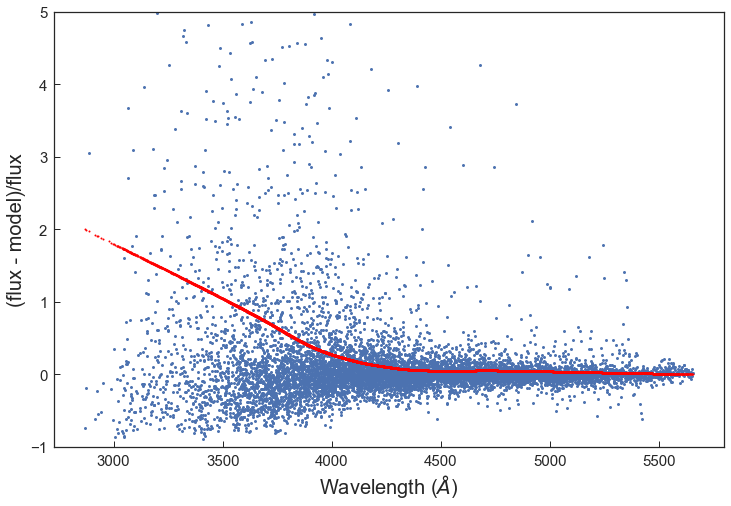

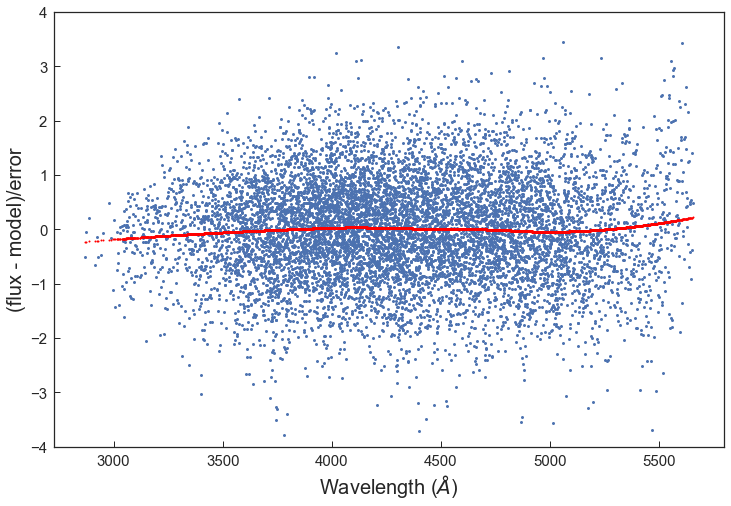

In [13]:
%matplotlib inline

plt.figure(figsize=[12,8])
plt.plot(waves[IDW],(mflux[IDW] - flux[IDW])/flux[IDW],'o',ms=3)
plt.plot(waves[IDW],S_res,'ro',ms=2)
plt.xlabel('Wavelength ($\AA$)',fontsize = 20)
plt.ylabel('(flux - model)/flux',fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(-1,5)
plt.show()
# plt.savefig('../plots/flx_err_flx.png')
plt.close()

plt.figure(figsize=[12,8])
plt.plot(waves[IDW],(mflux[IDW] - flux[IDW])/error[IDW],'o',ms=3)
plt.plot(waves[IDW],S_resers,'ro',ms=2)
plt.xlabel('Wavelength ($\AA$)',fontsize = 20)
plt.ylabel('(flux - model)/error',fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(-4,4)
plt.show()
# plt.savefig('../plots/flx_err_err.png')
plt.close()

In [14]:
eres = rzoo.zoo(df['resers'],df['wv'])

In [106]:
rmean = rzoo.rollapply(eres,50,'mean', fill = 'NA', align ='left')
rstd = rzoo.rollapply(eres,50,'sd', fill = 'NA', align ='left')

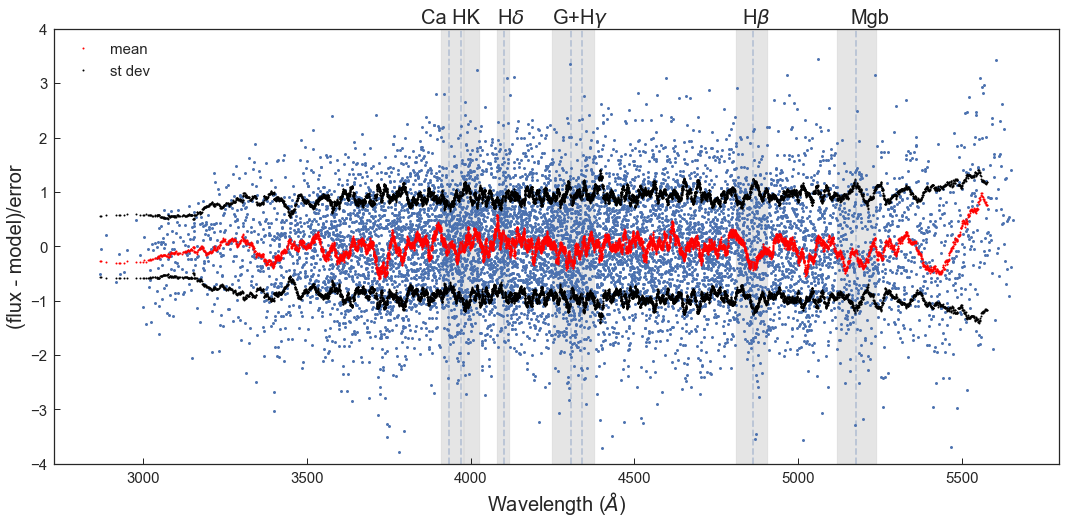

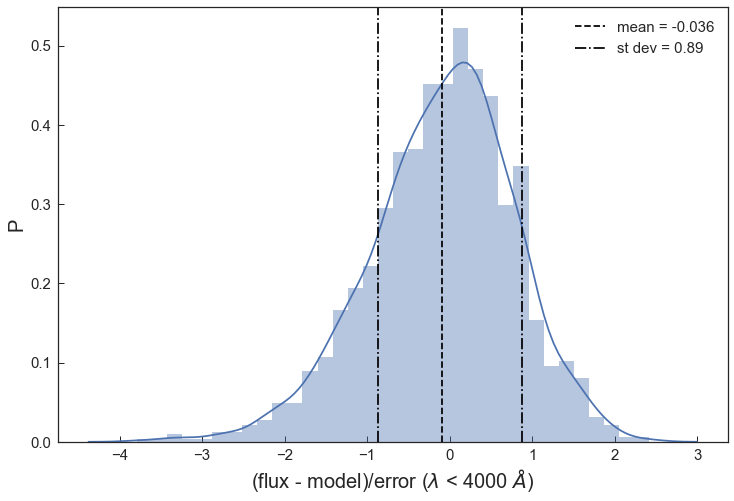

-0.0952840001804
0.873504504057


In [119]:
plt.figure(figsize=[18,8])
plt.plot(waves[IDW],(mflux[IDW] - flux[IDW])/error[IDW],'o',ms=3)
plt.plot(waves[IDW],rmean,'ro',ms=2, label = 'mean')
plt.plot(waves[IDW],rstd,'ko',ms=2, label = 'st dev')
plt.plot(waves[IDW],-np.array(rstd),'ko',ms=2)
plt.xlabel('Wavelength ($\AA$)',fontsize = 20)
plt.ylabel('(flux - model)/error',fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(-4,4)
plt.axvline(3934.777,linestyle='--', alpha=.3)
plt.axvline(3969.588,linestyle='--', alpha=.3)
plt.axvline(4102.89,linestyle='--', alpha=.3)
plt.axvline(4305.61,linestyle='--', alpha=.3)
plt.axvline(4341.68,linestyle='--', alpha=.3)
plt.axvline(4862.68,linestyle='--', alpha=.3)
plt.axvline(5176.7,linestyle='--', alpha=.3)
plt.axvspan(3910, 3980, color='k', alpha=.1)
plt.axvspan(3980, 4030, color='k', alpha=.1)
plt.axvspan(4080, 4120, color='k', alpha=.1)
plt.axvspan(4250, 4380, color='k', alpha=.1)
plt.axvspan(4810, 4910, color='k', alpha=.1)
plt.axvspan(5120, 5240, color='k', alpha=.1)
plt.text(3850,4.1,'Ca HK',fontsize=20)
plt.text(4080,4.1,'H$\delta$',fontsize=20)
plt.text(4250,4.1,'G+H$\gamma$',fontsize=20)
plt.text(4830,4.1,'H$\\beta$',fontsize=20)
plt.text(5160,4.1,'Mgb',fontsize=20)
plt.legend(fontsize = 15)
plt.show()
# plt.savefig('../plots/flx_err_m_std2.png')
plt.close()

plt.figure(figsize=[12,8])
sea.distplot((mflux[IDW][waves[IDW] < 3800] - flux[IDW][waves[IDW] < 3800])/error[IDW][waves[IDW] < 3800])
plt.axvline(np.mean((mflux[IDW][waves[IDW] < 3800] - flux[IDW][waves[IDW] < 3800])/error[IDW][waves[IDW] < 3800]),color='k',linestyle='--',label = 'mean = -0.036' )
plt.axvline(np.std((mflux[IDW][waves[IDW] < 3800] - flux[IDW][waves[IDW] < 3800])/error[IDW][waves[IDW] < 3800]),color='k',linestyle='-.',label = 'st dev = 0.89' )
plt.axvline(-np.std((mflux[IDW][waves[IDW] < 3800] - flux[IDW][waves[IDW] < 3800])/error[IDW][waves[IDW] < 3800]),color='k',linestyle='-.')
plt.ylabel('P',fontsize = 20)
plt.xlabel('(flux - model)/error ($\lambda$ < 4000 $\AA$)',fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(fontsize = 15)
plt.show()
# plt.savefig('../plots/flx_err_hist2.png')
plt.close()

print np.mean((mflux[IDW][waves[IDW] < 3800] - flux[IDW][waves[IDW] < 3800])/error[IDW][waves[IDW] < 3800])
print np.std((mflux[IDW][waves[IDW] < 3800] - flux[IDW][waves[IDW] < 3800])/error[IDW][waves[IDW] < 3800])

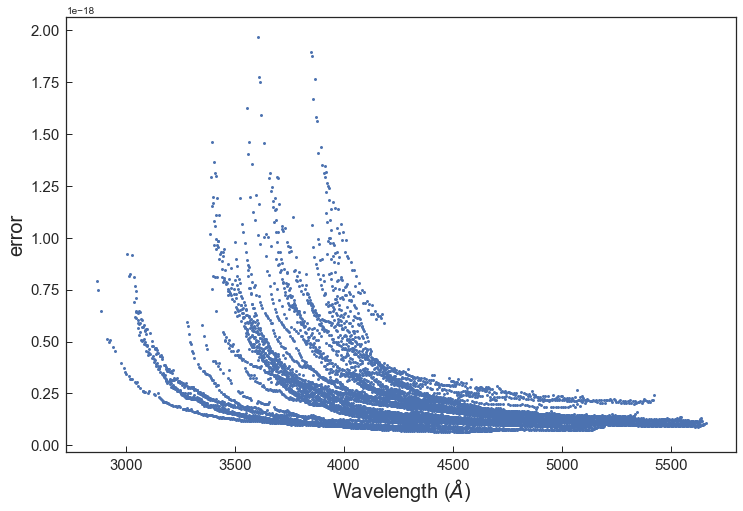

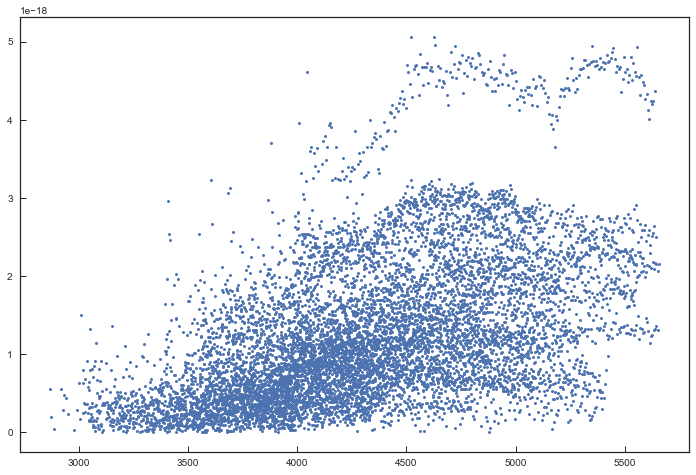

In [55]:
plt.figure(figsize=[12,8])
plt.plot(waves,error,'o',ms = 3)
plt.xlabel('Wavelength ($\AA$)',fontsize = 20)
plt.ylabel('error',fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=15)
# plt.ylim(-1,5)
plt.show()
# plt.savefig('../plots/flx_err_all_err.png')
plt.close()

plt.figure(figsize=[12,8])
plt.plot(waves,flux,'o',ms = 3)
plt.show()
plt.close()